# スプリント24 Seq2Seq

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#このSprintについて" data-toc-modified-id="このSprintについて-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>このSprintについて</a></span><ul class="toc-item"><li><span><a href="#Sprintの目的" data-toc-modified-id="Sprintの目的-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Sprintの目的</a></span></li><li><span><a href="#どのように学ぶか" data-toc-modified-id="どのように学ぶか-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>どのように学ぶか</a></span></li></ul></li><li><span><a href="#機械翻訳" data-toc-modified-id="機械翻訳-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>機械翻訳</a></span><ul class="toc-item"><li><span><a href="#【問題1】機械翻訳の実行とコードリーディング" data-toc-modified-id="【問題1】機械翻訳の実行とコードリーディング-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>【問題1】機械翻訳の実行とコードリーディング</a></span><ul class="toc-item"><li><span><a href="#コードリーディング" data-toc-modified-id="コードリーディング-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>コードリーディング</a></span></li></ul></li></ul></li><li><span><a href="#イメージキャプショニング" data-toc-modified-id="イメージキャプショニング-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>イメージキャプショニング</a></span><ul class="toc-item"><li><span><a href="#【問題2】イメージキャプショニングの学習済みモデルの実行" data-toc-modified-id="【問題2】イメージキャプショニングの学習済みモデルの実行-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>【問題2】イメージキャプショニングの学習済みモデルの実行</a></span></li><li><span><a href="#【問題3】Kerasで動かしたい場合はどうするかを調査" data-toc-modified-id="【問題3】Kerasで動かしたい場合はどうするかを調査-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>【問題3】Kerasで動かしたい場合はどうするかを調査</a></span><ul class="toc-item"><li><span><a href="#調査したところ、以下の方法がある。" data-toc-modified-id="調査したところ、以下の方法がある。-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>調査したところ、以下の方法がある。</a></span></li><li><span><a href="#pytorch2keras" data-toc-modified-id="pytorch2keras-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>pytorch2keras</a></span></li></ul></li></ul></li></ul></div>

## このSprintについて

### Sprintの目的
* 系列データに関する応用例を学ぶ

### どのように学ぶか
公開されているコードを元に学んでいきます。

## 機械翻訳


系列データに関する手法の基本的な活用例としては機械翻訳があります。これは系列データを入力し、系列データを出力する Sequence to Sequence の手法によって行えます。

### 【問題1】機械翻訳の実行とコードリーディング
以下のサンプルコードは、短い英語からフランス語への変換を行うものです。これを動かしてください。

keras/lstm_seq2seq.py at master · rstudio/keras
https://github.com/rstudio/keras/blob/master/vignettes/examples/lstm_seq2seq.py

その上でこのサンプルコードの各部分がどういった役割かを読み取り、まとめてください。以下のようにどこからどこの行が何をしているかを記述してください。

（例）

* 51から55行目 : ライブラリのimport
* 57から62行目 : ハイパーパラメータの設定

《文字単位のトークン化》

この実装ではテキストのベクトル化の際に、単語ではなく文字ごとを1つのトークンとして扱っています。

scikit-learnでBoWを計算するCountVectorizerの場合では、デフォルトの引数はanalyzer=’word’で単語を扱いますが、charやchar_wbとすることで文字を扱えるようになります。

charとchar_wbの2種類の方法があり、char_wbを指定した場合、n_gramが単語内からのみ作成されます。逆にcharは単語の区切りが関係なくn_gramが作成されます。This movie is very good.というテキストを3-gramでカウントする時、charではs mやe iといった単語をまたぐ数え方もしますが、char_wbではこれらを見ません。

sklearn.feature_extraction.text.CountVectorizer — scikit-learn 0.21.3 documentation

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [12]:
'''Sequence to sequence example in Keras (character-level).
This script demonstrates how to implement a basic character-level
sequence-to-sequence model. We apply it to translating
short English sentences into short French sentences,
character-by-character. Note that it is fairly unusual to
do character-level machine translation, as word-level
models are more common in this domain.
# Summary of the algorithm:
- We start with input sequences from a domain (e.g. English sentences)
    and correspding target sequences from another domain
    (e.g. French sentences).
- An encoder LSTM turns input sequences to 2 state vectors
    (we keep the last LSTM state and discard the outputs).
- A decoder LSTM is trained to turn the target sequences into
    the same sequence but offset by one timestep in the future,
    a training process called "teacher forcing" in this context.
    Is uses as initial state the state vectors from the encoder.
    Effectively, the decoder learns to generate `targets[t+1...]`
    given `targets[...t]`, conditioned on the input sequence.
- In inference mode, when we want to decode unknown input sequences, we:
    - Encode the input sequence into state vectors
    - Start with a target sequence of size 1
        (just the start-of-sequence character)
    - Feed the state vectors and 1-char target sequence
        to the decoder to produce predictions for the next character
    - Sample the next character using these predictions
        (we simply use argmax).
    - Append the sampled character to the target sequence
    - Repeat until we generate the end-of-sequence character or we
        hit the character limit.
# Data download:
English to French sentence pairs.
http://www.manythings.org/anki/fra-eng.zip
Lots of neat sentence pairs datasets can be found at:
http://www.manythings.org/anki/
# References:
- Sequence to Sequence Learning with Neural Networks
    https://arxiv.org/abs/1409.3215
- Learning Phrase Representations using
    RNN Encoder-Decoder for Statistical Machine Translation
    https://arxiv.org/abs/1406.1078
'''

from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

batch_size = 64  # Batch size for training.
epochs = 10  # Number of epochs to train for. defalt 100
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = './fra-eng/fra.txt'

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
lines = open(data_path).read().split('\n')

for line in lines[: min(num_samples, len(lines) - 1)]:
    #print(line.split('\t'))
    #print(len(line.split('\t')))
    input_text, target_text, _ = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

# Save model
model.save('s2s.h5')

# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    # Take one sequence (part of the training test)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 94
Max sequence length for inputs: 15
Max sequence length for outputs: 59
Epoch 1/10
125/125 [==============================] - 173s 1s/step - loss: 0.9076 - val_loss: 0.9164
Epoch 2/10
125/125 [==============================] - 126s 1s/step - loss: 0.7227 - val_loss: 0.7483
Epoch 3/10
125/125 [==============================] - 141s 1s/step - loss: 0.6117 - val_loss: 0.6705
Epoch 4/10
125/125 [==============================] - 97s 776ms/step - loss: 0.5523 - val_loss: 0.6291
Epoch 5/10
125/125 [==============================] - 126s 1s/step - loss: 0.5120 - val_loss: 0.6007
Epoch 6/10
125/125 [==============================] - 183s 1s/step - loss: 0.4800 - val_loss: 0.5698
Epoch 7/10
125/125 [==============================] - 80s 643ms/step - loss: 0.4536 - val_loss: 0.5540
Epoch 8/10
125/125 [==============================] - 67s 537ms/step - loss: 0.4319 - val_loss: 0.5288
Epoch 9/10
125/125 [=

#### コードリーディング
- 51-55行目 ライブラリーのインポート
- 57-62行目 パラメータ（batch_size, epoch, samples...）の設定
- 64-121行目 データのベクトル化、前処理
- 123-128行目 エンコーダー、入力シェイプの定義
- 130-139行目 デコーダーの準備
- 141-143行目 モデルの定義
- 145-150行目 モデルの学習
- 154-   行目 推論
- 222-   行目 出力

## イメージキャプショニング

他の活用例としてイメージキャプショニングがあります。画像に対する説明の文章を推定するタスクです。これは画像を入力し、系列データを出力する Image to Sequence の手法によって行えます。

pytorch-tutorial/tutorials/03-advanced/image_captioning at master · yunjey/pytorch-tutorial

イメージキャプショニングは学習に多くの時間がかかるため、ここでは学習済みの重みが公開されている実装を動かすことにします。Kerasには平易に扱える実装が公開されていないため、今回はPyTorchによる実装を扱います。

### 【問題2】イメージキャプショニングの学習済みモデルの実行
上記実装において 5. Test the model の項目を実行してください。また、自身で用意した画像に対しても文章を生成してください。これらに対してどういった文章が出力されたかを記録して提出してください。

データセットからの学習は行わず、学習済みの重みをダウンロードして利用します。

注意点として、デフォルトで設定されている重みのファイル名と、ダウンロードできる重みのファイル名は異なっています。ここは書き換える必要があります。

In [32]:
cd pytorch-tutorial/tutorials/03-advanced/image_captioning/

/Users/kazuki/diveintocode-ml/スプリント/pytorch-tutorial/tutorials/03-advanced/image_captioning


In [35]:
! python sample.py --image='png/example.png'

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /Users/kazuki/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth
100%|████████████████████████████████████████| 230M/230M [00:24<00:00, 9.83MB/s]
<start> a group of giraffes standing next to each other . <end>


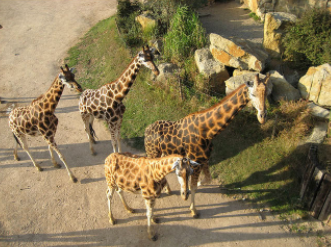

In [38]:
! python sample.py --image='png/image15.jpg'

<start> a black and white cat is laying on a couch . <end>


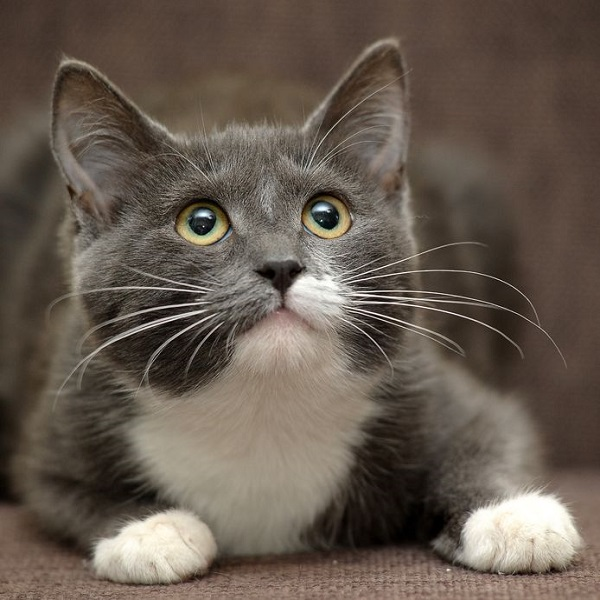

### 【問題3】Kerasで動かしたい場合はどうするかを調査
PyTorchによる実装を動かしましたが、何らかの理由からKerasで動かしたい状況が考えられます。どういった手順を踏むことになるか調査し、できるだけ詳しく説明してください。

特に今回はPyTorchのための学習済みの重みをKerasで使えるようにしたいので、その点については必ず触れてください。

#### 調査したところ、以下の方法がある。

- MMdnn  
Microsoft Researchにより開発が進められているオープンソースの深層学習モデルの変換と可視化を行うツール
https://github.com/Microsoft/MMdnn
- PyTorch to Keras model converter

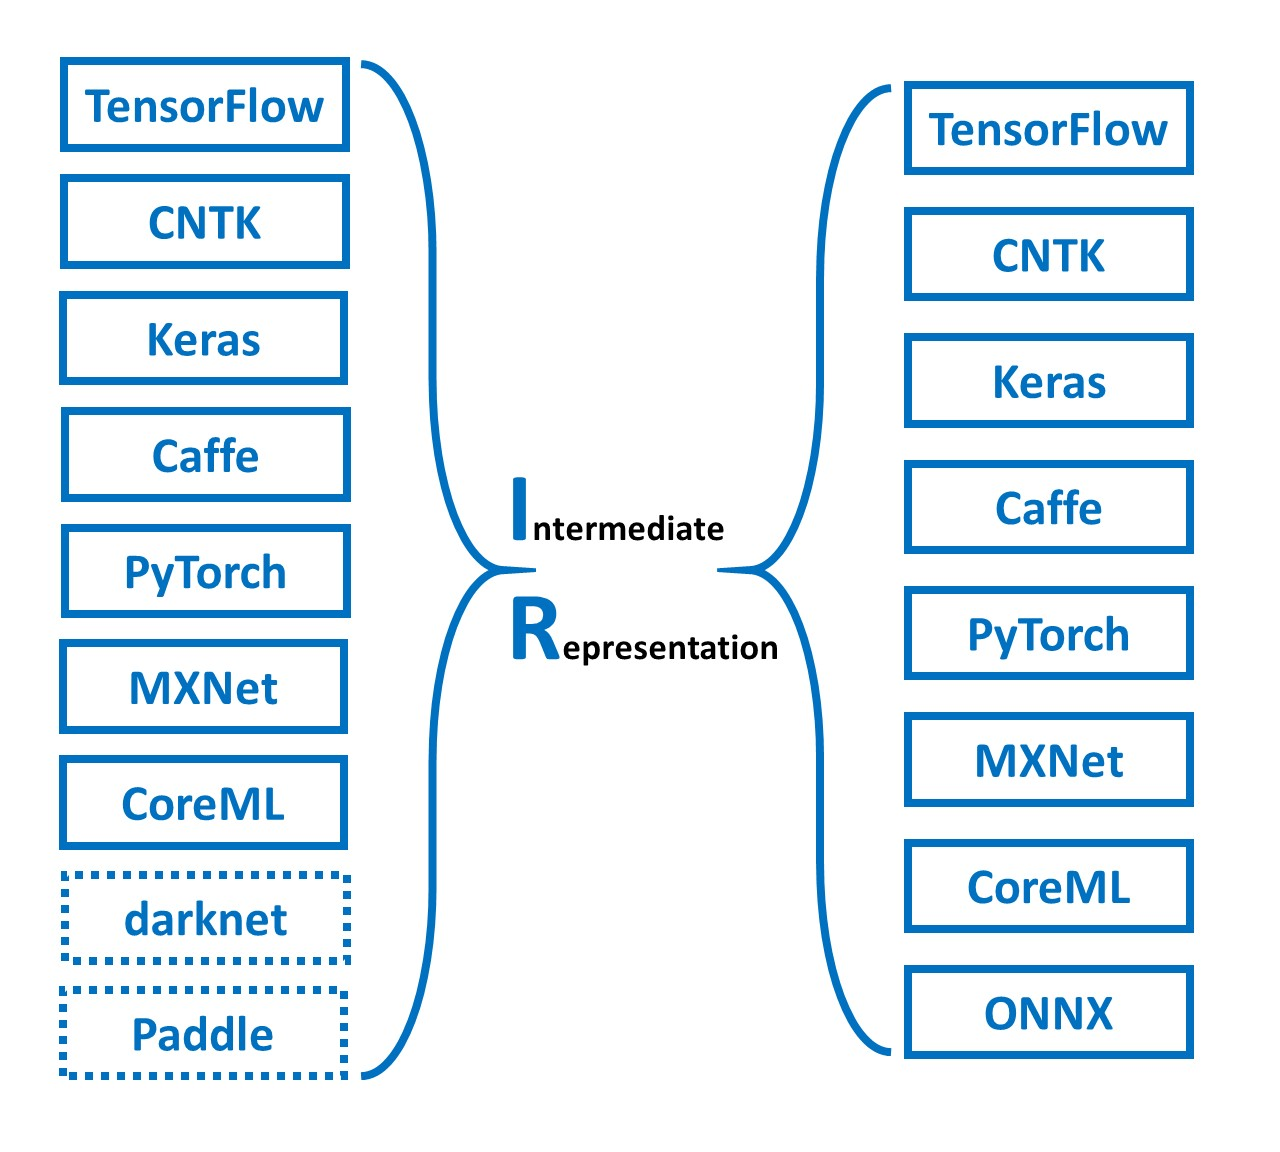

#### pytorch2keras
PyTorch to Keras model converter.

- Installation

pip install pytorch2keras 

1. First of all, you have to convert your model to Keras with this converter:

k_model = pytorch_to_keras(model, input_var, [(10, 32, 32,)], verbose=True, names='short')  
  
2. Now you have Keras model. You can save it as h5 file and then convert it with tensorflowjs_converter but it doesn't work sometimes. As alternative, you may get Tensorflow Graph and save it as a frozen model:  
  
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):  
      
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = \
            list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph


from keras import backend as K  
import tensorflow as tf  
frozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in k_model.outputs])

tf.train.write_graph(frozen_graph, ".", "my_model.pb", as_text=False)  
print([i for i in k_model.outputs])  

3. You will see the output layer name, so, now it's time to convert my_model.pb to tfjs model:  
  
tensorflowjs_converter  \  
    --input_format=tf_frozen_model \  
    --output_node_names='TANHTObs/Tanh' \  
    my_model.pb \  
    model_tfjs  
    
4. Thats all!  
  
const MODEL_URL = `model_tfjs/tensorflowjs_model.pb`;  
  
const WEIGHTS_URL = `model_tfjs/weights_manifest.json`;  
  
const model = await tf.loadFrozenModel(MODEL_URL, WEIGHTS_URL);  
  